In [1]:
from matplotlib import pyplot as plt
from jax.sharding import PartitionSpec as P, NamedSharding
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import numpy as np


NUM_DEVICES = jax.device_count()
mesh = jax.make_mesh(
    (NUM_DEVICES,),
    ('data',),
)

def named_sharding(*names: str | None) -> NamedSharding:
    return NamedSharding(mesh, P(*names))


class VisionTransformer(nnx.Module):
    """ Implements the ViT model, inheriting from `flax.nnx.Module`. """
    def __init__(
        self,
        num_classes: int = 1000, 
        in_channels: int = 3,
        img_size: int = 224,
        patch_size: int = 16,
        num_layers: int = 12,
        num_heads: int = 12,
        mlp_dim: int = 3072,
        hidden_size: int = 768,
        dropout_rate: float = 0.1,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        n_patches = (img_size // patch_size) ** 2
        
        # We shard the kernel of the convolution layer along the output feature dimension ('hidden_size').
        # This distributes the initial projection across devices.
        self.patch_embeddings = nnx.Conv(
            in_channels,
            hidden_size,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            use_bias=True,
            kernel_init=nnx.with_partitioning(
                nnx.initializers.lecun_normal(),
                (None, None, None, 'data'), # Shard along the output feature axis
            ),
            rngs=rngs,
        )

        initializer = jax.nn.initializers.truncated_normal(stddev=0.02)
        self.position_embeddings = nnx.Param(
            initializer(rngs.params(), (1, n_patches + 1, hidden_size), jnp.float32)
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
        self.cls_token = nnx.Param(jnp.zeros((1, 1, hidden_size)))

        self.encoder = nnx.Sequential(*[
            TransformerEncoder(hidden_size, mlp_dim, num_heads, dropout_rate, rngs=rngs)
            for i in range(num_layers)
        ])
        self.final_norm = nnx.LayerNorm(hidden_size, rngs=rngs)

        
        # We shard the final classification layer's kernel along its input dimension.
        self.classifier = nnx.Linear(
            hidden_size,
            num_classes,
            kernel_init=nnx.with_partitioning(
                nnx.initializers.lecun_normal(),
                ('data', None), # Shard along the input feature axis
            ),
            rngs=rngs,
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        patches = self.patch_embeddings(x)
        batch_size = patches.shape[0]
        patches = patches.reshape(batch_size, -1, patches.shape[-1])

        cls_token = jnp.tile(self.cls_token, [batch_size, 1, 1])
        x = jnp.concat([cls_token, patches], axis=1)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)

        x = self.encoder(embeddings)
        x = self.final_norm(x)
        x = x[:, 0]

        return self.classifier(x)


class TransformerEncoder(nnx.Module):
    """ A single transformer encoder block in the ViT model. """
    def __init__(
        self,
        hidden_size: int,
        mlp_dim: int,
        num_heads: int,
        dropout_rate: float = 0.0,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ) -> None:
        self.norm1 = nnx.LayerNorm(hidden_size, rngs=rngs)
        
        self.attn = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=hidden_size,
            dropout_rate=dropout_rate,
            broadcast_dropout=False,
            decode=False,
            deterministic=False,
            kernel_init=nnx.with_partitioning(
                nnx.initializers.xavier_uniform(),
                (None, 'data', None), # Shard Q,K,V kernels
            ),
            out_kernel_init=nnx.with_partitioning(
                nnx.initializers.xavier_uniform(),
                ('data', None), # Shard output projection
            ),
            rngs=rngs,
        )

        self.norm2 = nnx.LayerNorm(hidden_size, rngs=rngs)

        
        self.mlp = nnx.Sequential(
            nnx.Linear(
                hidden_size,
                mlp_dim,
                kernel_init=nnx.with_partitioning(
                    nnx.initializers.lecun_normal(), (None, 'data')
                ),
                rngs=rngs
            ),
            nnx.gelu,
            nnx.Dropout(dropout_rate, rngs=rngs),
            nnx.Linear(
                mlp_dim,
                hidden_size, # Corrected output dimension
                kernel_init=nnx.with_partitioning(
                    nnx.initializers.lecun_normal(), ('data', None)
                ),
                rngs=rngs
            ),
            nnx.Dropout(dropout_rate, rngs=rngs),
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

E0000 00:00:1754824545.450414   12624 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [2]:
!pip install -q grain
!pip install -q datasets

/usr/local/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from datasets import load_dataset

train_dataset = load_dataset("cifar100", split="train")
val_dataset = load_dataset("cifar100", split="test") 


print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

import numpy as np
from torchvision.transforms import v2 as T

img_size = 224

def to_np_array(pil_image):
  return np.asarray(pil_image.convert("RGB"))

def normalize(image):
    # Image preprocessing matches the one of pretrained ViT
    mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    std = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    image = image.astype(np.float32) / 255.0
    return (image - mean) / std


tv_train_transforms = T.Compose([
    T.RandomResizedCrop((img_size, img_size), scale=(0.8, 1.0)), # Adjusted scale for smaller 32x32 images
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2, 0.2, 0.2),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


tv_test_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


def get_transform(fn):
    def wrapper(batch):
        # The feature name for the image in CIFAR-100 is "img"
        batch["img"] = [
            fn(pil_image) for pil_image in batch["img"]
        ]
        # The labels are already 0-99, so no mapping is needed.
        return batch
    return wrapper


train_transforms = get_transform(tv_train_transforms)
val_transforms = get_transform(tv_test_transforms)

train_dataset = train_dataset.with_transform(train_transforms)
val_dataset = val_dataset.with_transform(val_transforms)

import grain.python as grain

seed = 12

train_batch_size_per_device = 16
val_batch_size_per_device = 2 * train_batch_size_per_device
train_batch_size = train_batch_size_per_device * NUM_DEVICES
val_batch_size = val_batch_size_per_device * NUM_DEVICES


train_sampler = grain.IndexSampler(
    len(train_dataset),
    shuffle=True,
    seed=seed,
    shard_options=grain.ShardByJaxProcess(), 
    num_epochs=None, # Run indefinitely
)
val_sampler = grain.IndexSampler(
    len(val_dataset),
    shuffle=False,
    seed=seed,
    shard_options=grain.ShardByJaxProcess(), 
    num_epochs=None, # Run indefinitely
)

# Loaders now use the per-device batch size
train_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,
    worker_count=4,
    operations=[grain.Batch(train_batch_size_per_device, drop_remainder=True)]
)
val_loader = grain.DataLoader(
    data_source=val_dataset,
    sampler=val_sampler,
    worker_count=4,
    operations=[grain.Batch(val_batch_size_per_device, drop_remainder=True)]
)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training dataset size: 50000
Validation dataset size: 10000


In [4]:
def vit_inplace_copy_weights(*, src_model, dst_model):
    assert isinstance(src_model, FlaxViTForImageClassification)
    assert isinstance(dst_model, VisionTransformer)

    tf_model_params = src_model.params
    tf_model_params_fstate = nnx.traversals.flatten_mapping(tf_model_params)

    # Notice the use of `flax.nnx.state`.
    flax_model_params = nnx.state(dst_model, nnx.Param)
    flax_model_params_fstate = dict(flax_model_params.flat_state())

    # Mapping from Flax parameter names to TF parameter names.
    params_name_mapping = {
        ("cls_token",): ("vit", "embeddings", "cls_token"),
        ("position_embeddings",): ("vit", "embeddings", "position_embeddings"),
        **{
            ("patch_embeddings", x): ("vit", "embeddings", "patch_embeddings", "projection", x)
            for x in ["kernel", "bias"]
        },
        **{
            ("encoder", "layers", i, "attn", y, x): (
                "vit", "encoder", "layer", str(i), "attention", "attention", y, x
            )
            for x in ["kernel", "bias"]
            for y in ["key", "value", "query"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "attn", "out", x): (
                "vit", "encoder", "layer", str(i), "attention", "output", "dense", x
            )
            for x in ["kernel", "bias"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "mlp", "layers", y1, x): (
                "vit", "encoder", "layer", str(i), y2, "dense", x
            )
            for x in ["kernel", "bias"]
            for y1, y2 in [(0, "intermediate"), (3, "output")]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, y1, x): (
                "vit", "encoder", "layer", str(i), y2, x
            )
            for x in ["scale", "bias"]
            for y1, y2 in [("norm1", "layernorm_before"), ("norm2", "layernorm_after")]
            for i in range(12)
        },
        **{
            ("final_norm", x): ("vit", "layernorm", x)
            for x in ["scale", "bias"]
        },
        **{
            ("classifier", x): ("classifier", x)
            for x in ["kernel", "bias"]
        }
    }

    nonvisited = set(flax_model_params_fstate.keys())

    for key1, key2 in params_name_mapping.items():
        assert key1 in flax_model_params_fstate, key1
        assert key2 in tf_model_params_fstate, (key1, key2)

        nonvisited.remove(key1)

        src_value = tf_model_params_fstate[key2]
        if key2[-1] == "kernel" and key2[-2] in ("key", "value", "query"):
            shape = src_value.shape
            src_value = src_value.reshape((shape[0], 12, 64))

        if key2[-1] == "bias" and key2[-2] in ("key", "value", "query"):
            src_value = src_value.reshape((12, 64))

        if key2[-4:] == ("attention", "output", "dense", "kernel"):
            shape = src_value.shape
            src_value = src_value.reshape((12, 64, shape[-1]))

        dst_value = flax_model_params_fstate[key1]
        assert src_value.shape == dst_value.value.shape, (key2, src_value.shape, key1, dst_value.value.shape)
        dst_value.value = src_value.copy()
        assert dst_value.value.mean() == src_value.mean(), (dst_value.value, src_value.mean())

    assert len(nonvisited) == 0, nonvisited
    # Notice the use of `flax.nnx.update` and `flax.nnx.State`.
    nnx.update(dst_model, nnx.State.from_flat_path(flax_model_params_fstate))


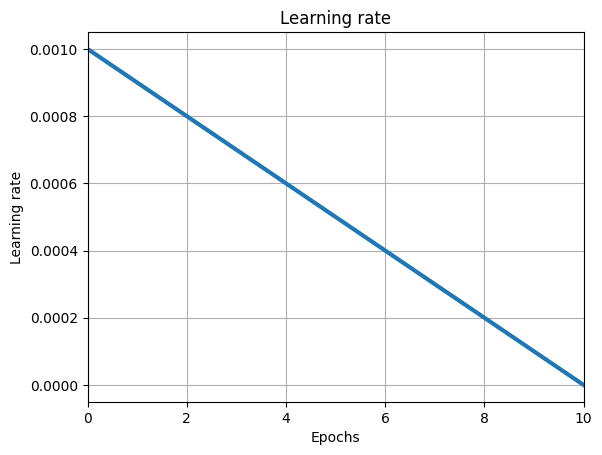

In [5]:
num_epochs = 10
learning_rate = 0.001
momentum = 0.8
total_steps = len(train_dataset) // train_batch_size

lr_schedule = optax.linear_schedule(learning_rate, 0.0, num_epochs * total_steps)

iterate_subsample = np.linspace(0, num_epochs * total_steps, 100)
plt.plot(
    np.linspace(0, num_epochs, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.title("Learning rate")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim((0, num_epochs))
plt.show()

In [6]:
from transformers import FlaxViTForImageClassification


print("STEP 1: Loading pretrained weights from Hugging Face on CPU...")
src_model = FlaxViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

print("STEP 2: Creating destination model with 1000 classes for weight transfer...")
model = VisionTransformer(num_classes=1000, rngs=nnx.Rngs(0))

print("STEP 3: Copying weights...")
vit_inplace_copy_weights(src_model=src_model, dst_model=model)
print("Successfully copied weights.")

print("STEP 4: Adapting classifier head for CIFAR-100 (100 classes)...")
model.classifier = nnx.Linear(
    768, # hidden_size
    100, # num_classes for CIFAR-100
    kernel_init=nnx.with_partitioning(
        nnx.initializers.lecun_normal(),
        ('data', None), # Shard along the input feature axis
    ),
    rngs=nnx.Rngs(1), # Use a different RNG seed for this new layer
)

print("Model is now prepared with pretrained weights and a new classifier head.")


@nnx.jit
def shard_model_and_create_optimizer(model: VisionTransformer):
    """
    Takes a prepared model, creates a corresponding optimizer, and applies
    sharding constraints to both within a JIT context.
    """
    print("JIT: Creating optimizer...")
    optimizer = nnx.Optimizer(model, optax.sgd(lr_schedule, momentum, nesterov=True))

    print("JIT: Sharding model state...")
    model_state = nnx.state(model)
    model_shardings = nnx.get_named_sharding(model_state, mesh)
    model_sharded_state = jax.lax.with_sharding_constraint(model_state, model_shardings)
    nnx.update(model, model_sharded_state)

    print("JIT: Sharding optimizer state...")
    optimizer_state = nnx.state(optimizer, nnx.optimizer.OptState)
    optimizer_shardings = nnx.get_named_sharding(optimizer_state, mesh)
    optimizer_sharded_state = jax.lax.with_sharding_constraint(optimizer_state, optimizer_shardings)
    nnx.update(optimizer, optimizer_sharded_state)

    return model, optimizer



print("\nSTEP 5: Calling JIT function to shard model and create optimizer...")

model, optimizer = shard_model_and_create_optimizer(model)
print("Model and optimizer are now sharded and ready for training!")

/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


STEP 1: Loading pretrained weights from Hugging Face on CPU...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


STEP 2: Creating destination model with 1000 classes for weight transfer...
STEP 3: Copying weights...
Successfully copied weights.
STEP 4: Adapting classifier head for CIFAR-100 (100 classes)...
Model is now prepared with pretrained weights and a new classifier head.

STEP 5: Calling JIT function to shard model and create optimizer...
JIT: Creating optimizer...
JIT: Sharding model state...
JIT: Sharding optimizer state...
Model and optimizer are now sharded and ready for training!


In [7]:
nnx.display(model)

In [8]:
def compute_losses_and_logits(model: nnx.Module, images: jax.Array, labels: jax.Array):
    logits = model(images)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels).mean()
    return loss, logits

@nnx.jit
def train_step(model: nnx.Module, optimizer: nnx.Optimizer, batch):
    images, labels = batch
    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, images, labels)
    optimizer.update(grads)
    return loss

@nnx.jit
def eval_step(model: nnx.Module, batch, eval_metrics: nnx.MultiMetric):
    images, labels = batch
    loss, logits = compute_losses_and_logits(model, images, labels)
    eval_metrics.update(loss=loss, logits=logits, labels=labels)

In [9]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

In [10]:
import tqdm

train_metrics_history = {"train_loss": []}
eval_metrics_history = {"val_loss": [], "val_accuracy": []}
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
steps_per_epoch = len(train_dataset) // train_batch_size

def train_one_epoch(epoch, train_iterator):
    model.train()
    with tqdm.tqdm(desc=f"[train] epoch: {epoch+1}/{num_epochs}", total=steps_per_epoch, bar_format=bar_format) as pbar:
        for i in range(steps_per_epoch):
            batch = next(train_iterator)
            
            # Explicitly shard the data batch across all devices along the 'data' (batch) axis.
            # `jax.device_put` splits the array from axis 0 and sends one chunk to each device.
            sharded_batch = jax.device_put(
                (jnp.array(batch['img']), jnp.array(batch['fine_label'])),
                named_sharding('data')
            )
            loss = train_step(model, optimizer, sharded_batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)

def evaluate_model(epoch, val_iterator):
    model.eval()
    eval_metrics.reset()
    steps_per_val_epoch = len(val_dataset) // val_batch_size
    for _ in range(steps_per_val_epoch):
        val_batch = next(val_iterator)
        sharded_batch = jax.device_put(
            (jnp.array(val_batch['img']), jnp.array(val_batch['fine_label'])),
            named_sharding('data')
        )
        eval_step(model, sharded_batch, eval_metrics)

    computed_metrics = eval_metrics.compute()
    for metric, value in computed_metrics.items():
        eval_metrics_history[f'val_{metric}'].append(value)
    print(f"\n[val] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['val_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['val_accuracy'][-1]:0.4f}\n")

In [11]:
train_iterator = iter(train_loader)
val_iterator = iter(val_loader)

for epoch in range(num_epochs):
    train_one_epoch(epoch, train_iterator) 
    evaluate_model(epoch, val_iterator) 

[train] epoch: 1/10[390/390], loss=1.79 [01:53<00:00]



[val] epoch: 1/10
- total loss: 1.6072
- Accuracy: 0.6987



[train] epoch: 2/10[390/390], loss=1.08 [00:29<00:00] 



[val] epoch: 2/10
- total loss: 0.8255
- Accuracy: 0.8197



[train] epoch: 3/10[390/390], loss=0.611 [00:32<00:00]



[val] epoch: 3/10
- total loss: 0.6358
- Accuracy: 0.8365



[train] epoch: 4/10[390/390], loss=0.463 [00:32<00:00] 



[val] epoch: 4/10
- total loss: 0.5121
- Accuracy: 0.8638



[train] epoch: 5/10[390/390], loss=0.912 [00:33<00:00] 



[val] epoch: 5/10
- total loss: 0.4413
- Accuracy: 0.8974



[train] epoch: 6/10[390/390], loss=0.522 [00:33<00:00] 



[val] epoch: 6/10
- total loss: 0.4535
- Accuracy: 0.8798



[train] epoch: 7/10[390/390], loss=0.186 [00:33<00:00] 



[val] epoch: 7/10
- total loss: 0.3922
- Accuracy: 0.8926



[train] epoch: 8/10[390/390], loss=0.23 [00:33<00:00]  



[val] epoch: 8/10
- total loss: 0.4066
- Accuracy: 0.8926



[train] epoch: 9/10[390/390], loss=0.475 [00:33<00:00] 



[val] epoch: 9/10
- total loss: 0.3848
- Accuracy: 0.9014



[train] epoch: 10/10[390/390], loss=0.89 [00:33<00:00]  



[val] epoch: 10/10
- total loss: 0.4095
- Accuracy: 0.8878



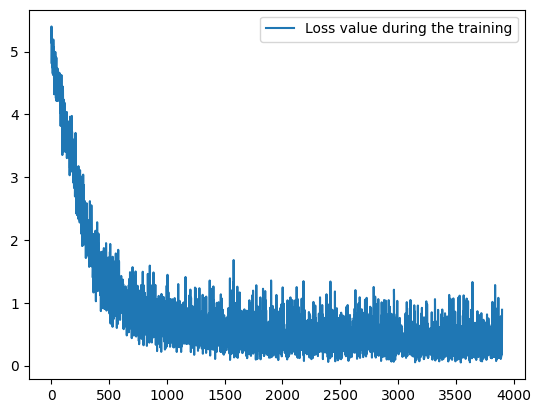

In [12]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training") 
plt.legend()

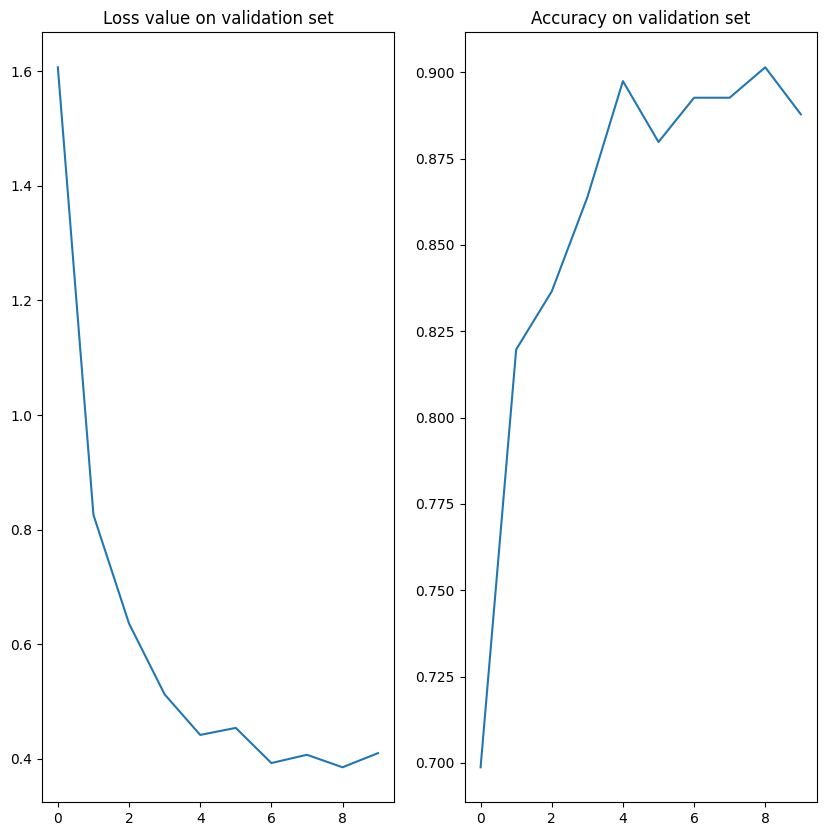

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on validation set")
axs[0].plot(eval_metrics_history["val_loss"])
axs[1].set_title("Accuracy on validation set")
axs[1].plot(eval_metrics_history["val_accuracy"])